# Ocean basin trends of Eddy Kinetic Energy and Sea surface temperature gradients ($\left|\nabla \mathrm{SST} \right|$)

This Jupyter notebook reproduces Figure 4 of the manuscript "Global changes in oceanic mesoscale currents over the satellite altimetry record".

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
import pandas as pd
# Inline plotting
%matplotlib inline

In [2]:
# Import plot utilities
from plot_utils import (truncate_colormap, ccrs_land, add_patches, 
                        area, plot_ocean_basins, significance_mk, plot_bars,
                        compute_trends)

In [3]:
# Load ocean basin masks
ocean_basins = xr.open_dataset('../datasets/ocean_basins_and_dynamical_masks.nc')

In [4]:
print(ocean_basins) # This dataset includes all the mask used in the study in a 1°x 1° grid

<xarray.Dataset>
Dimensions:                          (lat: 180, lon: 360)
Coordinates:
  * lon                              (lon) float32 0.5 1.5 2.5 ... 358.5 359.5
  * lat                              (lat) float32 -89.5 -88.5 ... 88.5 89.5
Data variables:
    indian_ocean_mask                (lat, lon) float64 ...
    pacific_ocean_mask               (lat, lon) float64 ...
    atlantic_ocean_mask              (lat, lon) float64 ...
    southern_ocean_mask              (lat, lon) float64 ...
    remaining_processes_mask         (lat, lon) float32 ...
    boundarycurrents_processes_mask  (lat, lon) float32 ...
    gyres_processes_mask             (lat, lon) float32 ...
    equator_processes_mask           (lat, lon) float32 ...
    acc_processes_mask               (lat, lon) float32 ...
Attributes:
    title:         Ocean geographical basins and ocean dynamical processes masks
    Description:   Geographical regions consist on the following ocean basins...
    Publication:   Dataset

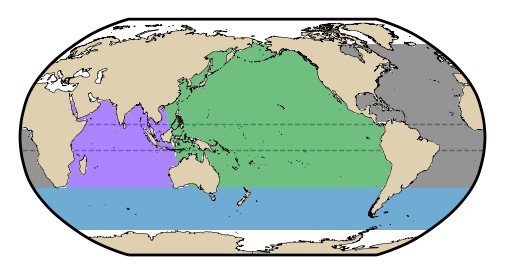

In [5]:
# Plot basin masks
fig = plt.figure(figsize=(3,3), dpi=200)
ax1 = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude=180))
# Display basins:
plot_ocean_basins(ax1,ocean_basins);

### Import EKE timeseries

In [6]:
dataset_EKE = xr.open_dataset('../datasets/EKE_timeseries.nc')

In [7]:
rho=1025
#Compute grid area for area-weigthed EKE
area = area(dataset_EKE.lat, dataset_EKE.lon)

In [8]:
# Compute area-weigthed EKE
EKE_area_weighted = (rho*dataset_EKE*area) # Units J m^{-1}

Slice data between 65°S - 65°N and create dataset without the equator (9°S - 9°N).

In [9]:
# Global EKE time-series
EKE_timeseries=EKE_area_weighted.where(abs(dataset_EKE.lat)<65)
# Global without tropics (between 9°S-9°N)
EKE_no_tropics_timeseries=EKE_area_weighted.where(abs(dataset_EKE.lat)<65).where(abs(dataset_EKE.lat)>9)

In [10]:
# Global dataset 
global_EKE = EKE_timeseries.EKE # Units PJ m^{-1}
global_EKE_no_tropics = EKE_no_tropics_timeseries.EKE

In [11]:
# Regional masked datasets
southern_EKE = (global_EKE).where(ocean_basins.southern_ocean_mask==True) # Units J m^{-1}
indian_EKE   = (global_EKE).where(ocean_basins.indian_ocean_mask==True) # Units J m^{-1}
pacific_EKE  = (global_EKE).where(ocean_basins.pacific_ocean_mask==True) # Units J m^{-1}
atlantic_EKE = (global_EKE).where(ocean_basins.atlantic_ocean_mask==True) # Units J m^{-1}
# No tropics
southern_EKE_no_tropics = (global_EKE_no_tropics).where(ocean_basins.southern_ocean_mask==True) # Units J m^{-1}
indian_EKE_no_tropics   = (global_EKE_no_tropics).where(ocean_basins.indian_ocean_mask==True) # Units J m^{-1}
pacific_EKE_no_tropics  = (global_EKE_no_tropics).where(ocean_basins.pacific_ocean_mask==True) # Units J m^{-1}
atlantic_EKE_no_tropics = (global_EKE_no_tropics).where(ocean_basins.atlantic_ocean_mask==True) # Units J m^{-1}

Integrate over region (Global, Southern Ocean, Indian Ocean, Pacific Ocean, and Atlantic Ocean) and convert units from $J m^{-1}$ to $PJ m^{-1}$ (i.e. PetaJoules = $\times10^{15}$)

In [12]:
global_integrated_EKE = global_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
global_integrated_EKE_no_tropics = global_EKE_no_tropics.sum(('lon','lat'))/1e15 # Units PJ m^{-1}

In [13]:
southern_integrated_EKE = southern_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
indian_integrated_EKE   = indian_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
pacific_integrated_EKE  = pacific_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
atlantic_integrated_EKE = atlantic_EKE.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
# No tropics
southern_integrated_EKE_no_tropics = southern_EKE_no_tropics.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
indian_integrated_EKE_no_tropics   = indian_EKE_no_tropics.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
pacific_integrated_EKE_no_tropics  = pacific_EKE_no_tropics.sum(('lon','lat'))/1e15 # Units PJ m^{-1}
atlantic_integrated_EKE_no_tropics = atlantic_EKE_no_tropics.sum(('lon','lat'))/1e15 # Units PJ m^{-1}

Drop zeros at the beginning and end of record due to pre-processing (i.e. 12 month rolling average)

In [14]:
global_integrated_EKE = global_integrated_EKE.where(global_integrated_EKE!=0).dropna('time')
global_integrated_EKE_no_tropics = global_integrated_EKE_no_tropics.where(global_integrated_EKE_no_tropics!=0).dropna('time')

In [15]:
southern_integrated_EKE = southern_integrated_EKE.where(southern_integrated_EKE!=0).dropna('time')
indian_integrated_EKE = indian_integrated_EKE.where(indian_integrated_EKE!=0).dropna('time')
pacific_integrated_EKE = pacific_integrated_EKE.where(pacific_integrated_EKE!=0).dropna('time')
atlantic_integrated_EKE = atlantic_integrated_EKE.where(atlantic_integrated_EKE!=0).dropna('time')
# No tropics
southern_integrated_EKE_no_tropics = southern_integrated_EKE_no_tropics.where(southern_integrated_EKE!=0).dropna('time')
indian_integrated_EKE_no_tropics = indian_integrated_EKE_no_tropics.where(indian_integrated_EKE!=0).dropna('time')
pacific_integrated_EKE_no_tropics = pacific_integrated_EKE_no_tropics.where(pacific_integrated_EKE!=0).dropna('time')
atlantic_integrated_EKE_no_tropics = atlantic_integrated_EKE_no_tropics.where(atlantic_integrated_EKE!=0).dropna('time')

In [16]:
global_integrated_EKE

<xarray.DataArray 'EKE' (time: 9564)>
array([7.40809625, 7.40507298, 7.40182838, ..., 7.73864119, 7.73850523,
       7.73831664])
Coordinates:
  * time     (time) datetime64[ns] 1993-07-02 1993-07-03 ... 2019-09-07

### Import mesoscale SST gradients

In [17]:
dataset_SST_grad = xr.open_dataset('../datasets/SST_grads_decomposition_timeseries.nc')

Compute area-weigthed SST gradients ($\left|\nabla \mathrm{SST} \right|$)

In [18]:
mesoscale_SST_grad_area_weighted = (dataset_SST_grad.SST_grad_small_scale)*area # Units °C m^{-1}

Slice data between 65°S - 65°N and create dataset without the equator (9°S - 9°N).

In [19]:
# Global mesoscale SST gradient time-series
mes_SST_grad_timeseries=mesoscale_SST_grad_area_weighted.where(abs(dataset_SST_grad.lat)<65)
# Global without tropics (between 9°S-9°N)
mes_SST_grad_no_tropics_timeseries=mesoscale_SST_grad_area_weighted.where(abs(dataset_SST_grad.lat)<65).where(abs(dataset_SST_grad.lat)>9)

In [20]:
global_m_SST_grad = mes_SST_grad_timeseries # Units °C m
global_m_SST_grad_no_tropics = mes_SST_grad_no_tropics_timeseries # Units °C m

In [21]:
southern_m_SST_grad = (mes_SST_grad_timeseries).where(ocean_basins.southern_ocean_mask==True) # Units °C m
indian_m_SST_grad   = (mes_SST_grad_timeseries).where(ocean_basins.indian_ocean_mask==True) # Units °C m
pacific_m_SST_grad  = (mes_SST_grad_timeseries).where(ocean_basins.pacific_ocean_mask==True) # Units °C m
atlantic_m_SST_grad = (mes_SST_grad_timeseries).where(ocean_basins.atlantic_ocean_mask==True) # Units °C m
# No tropics
southern_m_SST_grad_no_tropics = (global_m_SST_grad_no_tropics).where(ocean_basins.southern_ocean_mask==True) # Units °C m
indian_m_SST_grad_no_tropics   = (global_m_SST_grad_no_tropics).where(ocean_basins.indian_ocean_mask==True) # Units °C m
pacific_m_SST_grad_no_tropics  = (global_m_SST_grad_no_tropics).where(ocean_basins.pacific_ocean_mask==True) # Units °C m
atlantic_m_SST_grad_no_tropics = (global_m_SST_grad_no_tropics).where(ocean_basins.atlantic_ocean_mask==True) # Units °C m

Integrate over region (Global, Southern Ocean, Indian Ocean, Pacific Ocean, and Atlantic Ocean) with units of $^\circ C\ m$. 

In [22]:
global_integrated_m_SST_grad = global_m_SST_grad.sum(('lon','lat'))/1e8  # Units °C m\
global_integrated_m_SST_grad_no_tropics = global_m_SST_grad_no_tropics.sum(('lon','lat'))/1e8  # Units °C m\

In [23]:
southern_integrated_m_SST_grad = southern_m_SST_grad.sum(('lon','lat'))/1e8  # Units °C m
indian_integrated_m_SST_grad   = indian_m_SST_grad.sum(('lon','lat'))/1e8  # Units °C m
pacific_integrated_m_SST_grad  = pacific_m_SST_grad.sum(('lon','lat'))/1e8  # Units °C m
atlantic_integrated_m_SST_grad = atlantic_m_SST_grad.sum(('lon','lat'))/1e8  # Units °C m
# No tropics
southern_integrated_m_SST_grad_no_tropics = southern_m_SST_grad_no_tropics.sum(('lon','lat'))/1e8  # Units °C m
indian_integrated_m_SST_grad_no_tropics   = indian_m_SST_grad_no_tropics.sum(('lon','lat'))/1e8  # Units °C m
pacific_integrated_m_SST_grad_no_tropics  = pacific_m_SST_grad_no_tropics.sum(('lon','lat'))/1e8  # Units °C m
atlantic_integrated_m_SST_grad_no_tropics = atlantic_m_SST_grad_no_tropics.sum(('lon','lat'))/1e8  # Units °C m

Drop zeros at the beginning and end of record due to pre-processing (i.e. 12 month rolling average)

In [24]:
global_integrated_m_SST_grad = global_integrated_m_SST_grad.where(global_integrated_m_SST_grad!=0).dropna('time')
global_integrated_m_SST_grad_no_tropics = global_integrated_m_SST_grad_no_tropics.where(global_integrated_m_SST_grad!=0).dropna('time')

In [25]:
southern_integrated_m_SST_grad = southern_integrated_m_SST_grad.where(southern_integrated_m_SST_grad!=0).dropna('time')
indian_integrated_m_SST_grad   = indian_integrated_m_SST_grad.where(indian_integrated_m_SST_grad!=0).dropna('time')
pacific_integrated_m_SST_grad  = pacific_integrated_m_SST_grad.where(pacific_integrated_m_SST_grad!=0).dropna('time')
atlantic_integrated_m_SST_grad = atlantic_integrated_m_SST_grad.where(atlantic_integrated_m_SST_grad!=0).dropna('time')
# No tropics
southern_integrated_m_SST_grad_no_tropics = southern_integrated_m_SST_grad_no_tropics.where(southern_integrated_m_SST_grad!=0).dropna('time')
indian_integrated_m_SST_grad_no_tropics   = indian_integrated_m_SST_grad_no_tropics.where(indian_integrated_m_SST_grad!=0).dropna('time')
pacific_integrated_m_SST_grad_no_tropics  = pacific_integrated_m_SST_grad_no_tropics.where(pacific_integrated_m_SST_grad!=0).dropna('time')
atlantic_integrated_m_SST_grad_no_tropics = atlantic_integrated_m_SST_grad_no_tropics.where(atlantic_integrated_m_SST_grad!=0).dropna('time')

In [26]:
print(global_integrated_m_SST_grad)

<xarray.DataArray (time: 10229)>
array([12.514028, 12.514318, 12.514765, ..., 12.601461, 12.59754 ,
       12.595429], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-07-01T12:00:00 ... 2020-07-02T12:00:00


Download MEI v2 dataset from [NOAA mei website](https://psl.noaa.gov/enso/mei/)

In [27]:
# #Uncoment this cell to download the Mei v2 dataset
# !wget https://psl.noaa.gov/enso/mei/data/meiv2.data -P ../datasets/

In [28]:
data = pd.read_csv('../datasets/meiv2.data', header=None,skiprows=1, skipfooter=4, delim_whitespace=True,engine='python')
data = data.set_index(0)

In [29]:
enso=data.loc[slice(1980,2017)].T.unstack()#.rolling(13).mean().dropna()
enso_date=pd.date_range(start='1/1/1980', end='1/1/2018', freq='M')
dic={'time':enso_date,'ENSO':enso.values}

ensod=pd.DataFrame.from_dict(dic).set_index('time')

In [30]:
enso_percentile=ensod.loc[slice('1993','2018')].quantile(.90)
enso_mask=ensod.loc[slice('1994','2018')].where(ensod>enso_percentile).where(ensod<enso_percentile,1)
enso_mask_values=np.squeeze(enso_mask.values.T)

#### Compute slopes and intercepts:

In [31]:
slope_SST_grad_global, intercept_SST_grad_global     = compute_trends(global_integrated_m_SST_grad)
slope_SST_grad_pacific, intercept_SST_grad_pacific   = compute_trends(pacific_integrated_m_SST_grad)
slope_SST_grad_indian, intercept_SST_grad_indian     = compute_trends(indian_integrated_m_SST_grad)
slope_SST_grad_atlantic, intercept_SST_grad_atlantic = compute_trends(atlantic_integrated_m_SST_grad)
slope_SST_grad_southern, intercept_SST_grad_southern = compute_trends(southern_integrated_m_SST_grad)

In [32]:
slope_SST_grad_global_no_tropics, intercept_SST_grad_global_no_tropics     = compute_trends(global_integrated_m_SST_grad_no_tropics)
slope_SST_grad_pacific_no_tropics, intercept_SST_grad_pacific_no_tropics   = compute_trends(pacific_integrated_m_SST_grad_no_tropics)
slope_SST_grad_indian_no_tropics, intercept_SST_grad_indian_no_tropics     = compute_trends(indian_integrated_m_SST_grad_no_tropics)
slope_SST_grad_atlantic_no_tropics, intercept_SST_grad_atlantic_no_tropics = compute_trends(atlantic_integrated_m_SST_grad_no_tropics)
slope_SST_grad_southern_no_tropics, intercept_SST_grad_southern_no_tropics = compute_trends(southern_integrated_m_SST_grad_no_tropics)

In [33]:
slope_EKE_global, intercept_EKE_global = compute_trends(global_integrated_EKE)
slope_EKE_pacific, intercept_EKE_pacific = compute_trends(pacific_integrated_EKE)
slope_EKE_indian, intercept_EKE_indian = compute_trends(indian_integrated_EKE)
slope_EKE_atlantic, intercept_EKE_atlantic = compute_trends(atlantic_integrated_EKE)
slope_EKE_southern, intercept_EKE_southern = compute_trends(southern_integrated_EKE)

In [34]:
slope_EKE_global_no_tropics, intercept_EKE_global_no_tropics     = compute_trends(global_integrated_EKE_no_tropics)
slope_EKE_pacific_no_tropics, intercept_EKE_pacific_no_tropics   = compute_trends(pacific_integrated_EKE_no_tropics)
slope_EKE_indian_no_tropics, intercept_EKE_indian_no_tropics     = compute_trends(indian_integrated_EKE_no_tropics)
slope_EKE_atlantic_no_tropics, intercept_EKE_atlantic_no_tropics = compute_trends(atlantic_integrated_EKE_no_tropics)
slope_EKE_southern_no_tropics, intercept_EKE_southern_no_tropics = compute_trends(southern_integrated_EKE_no_tropics)

## Plot Figure 4 of manuscript

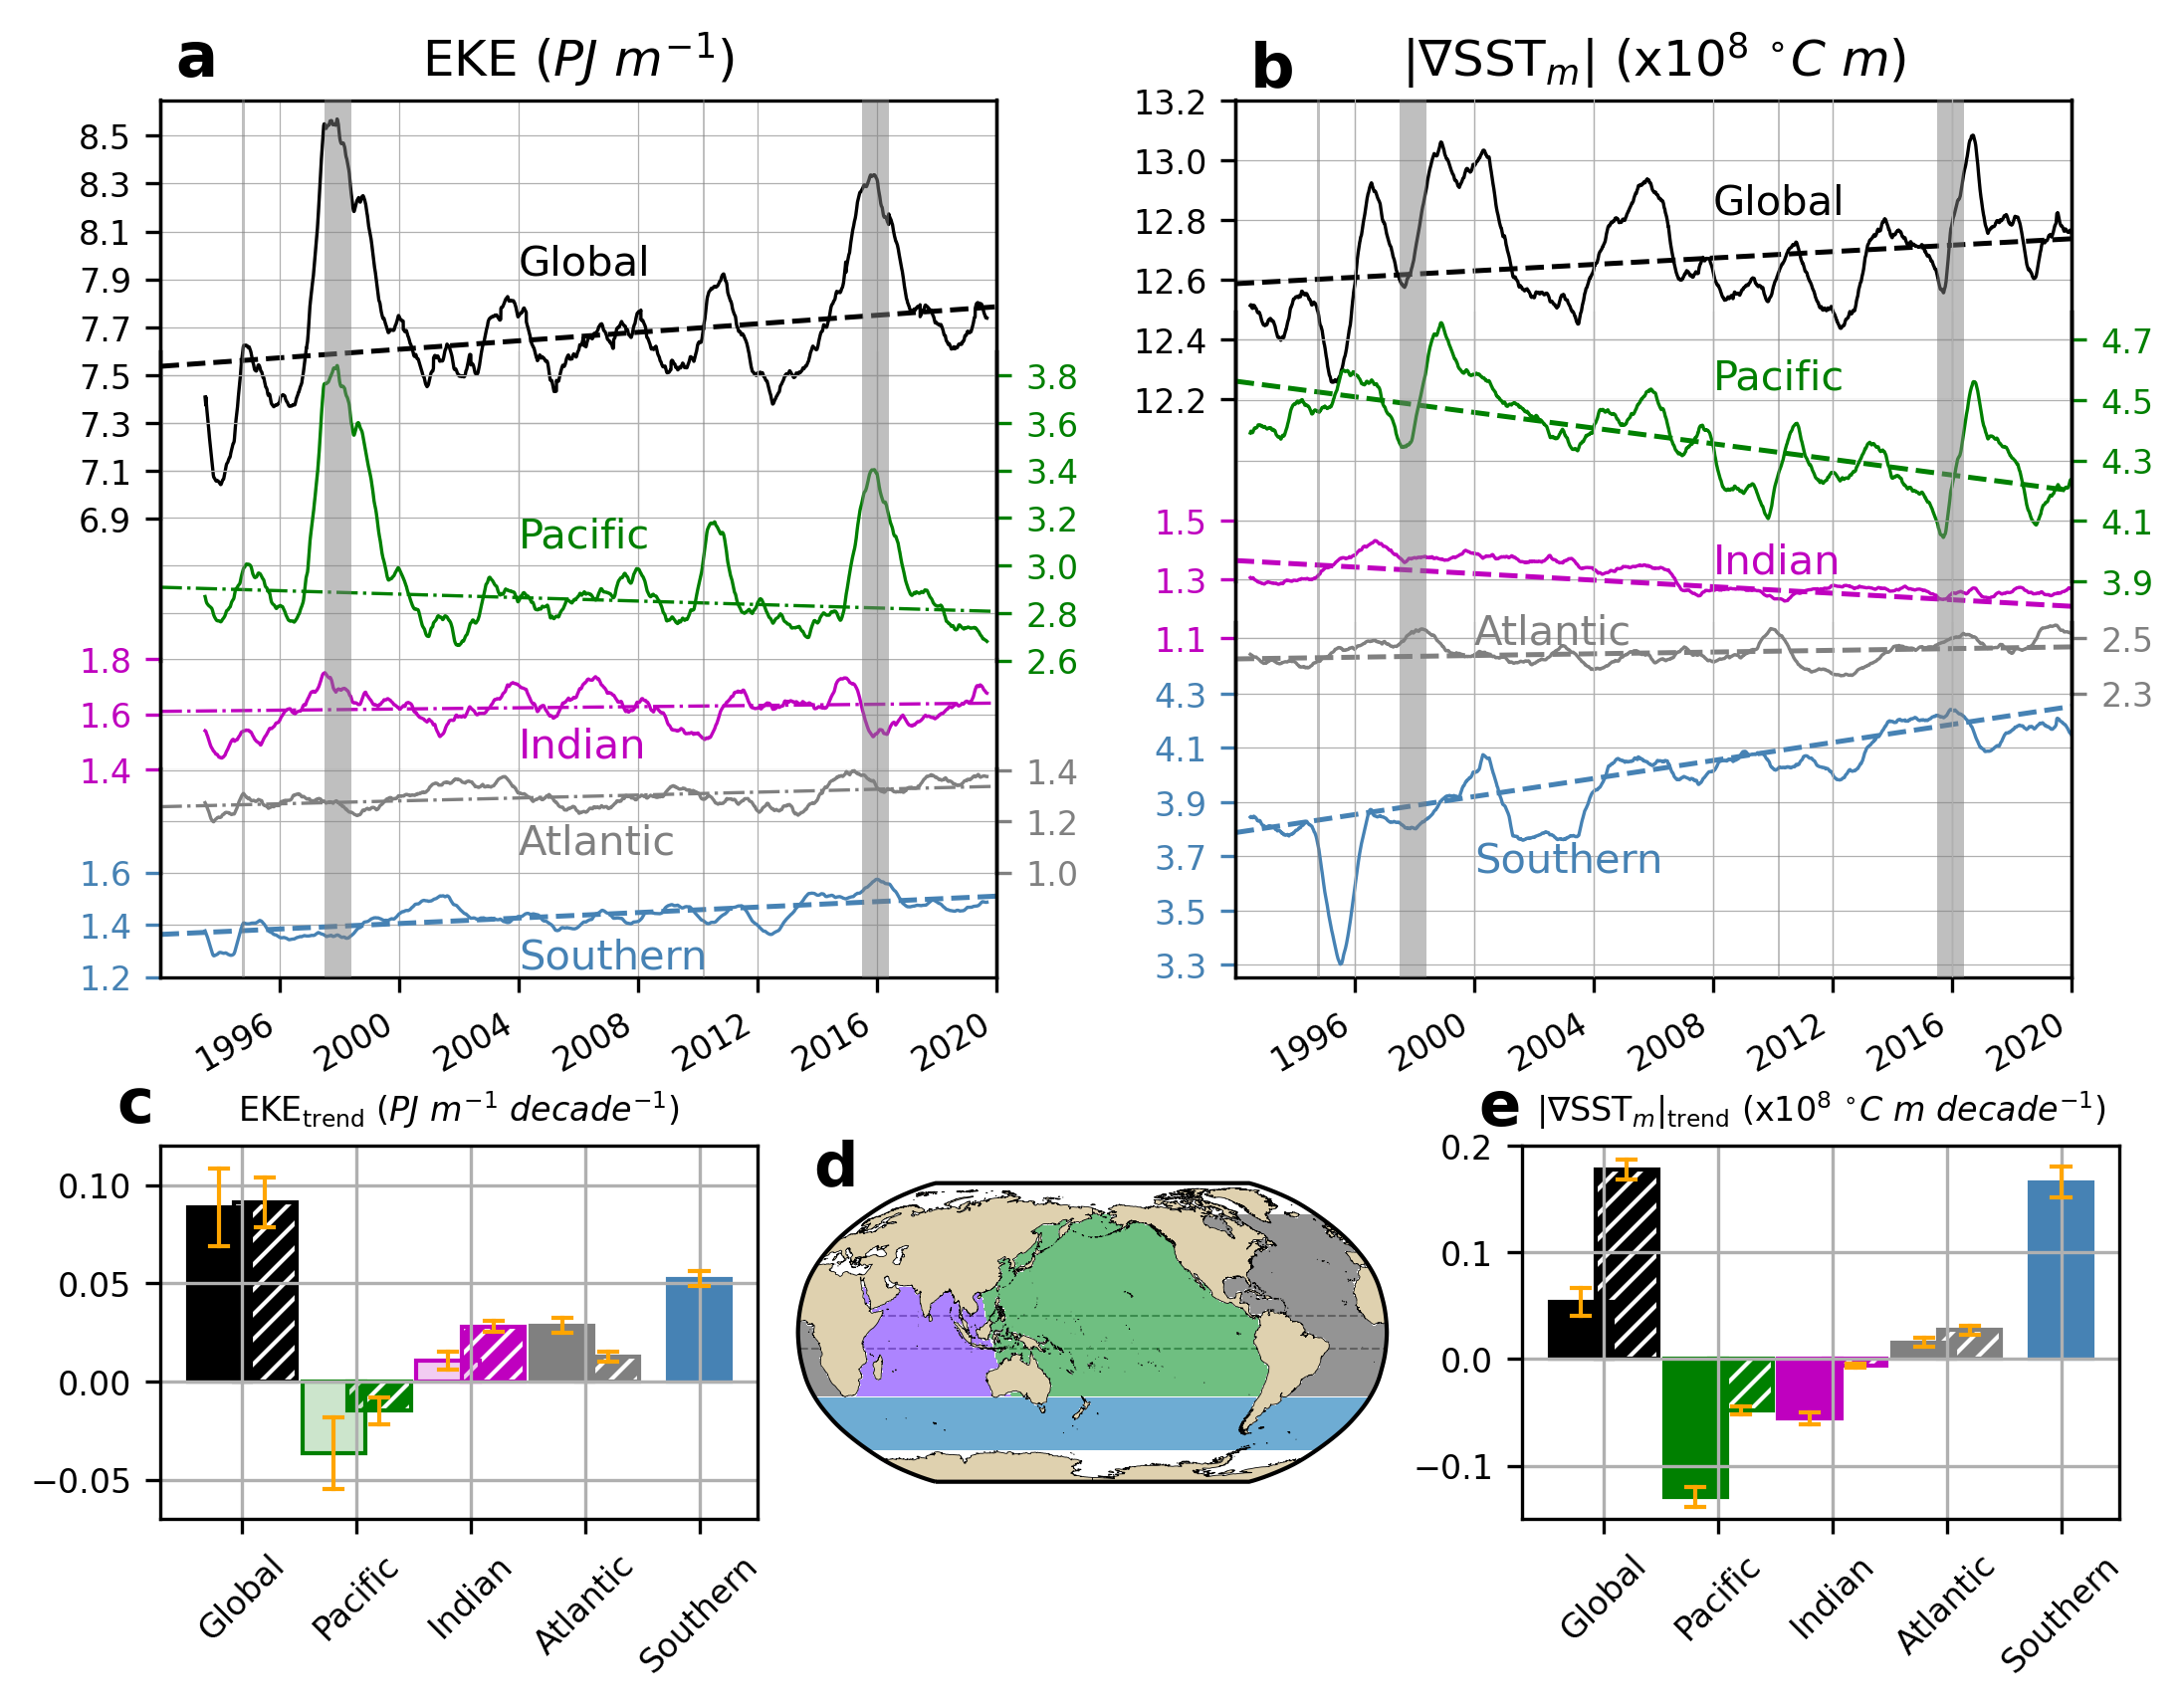

In [35]:
fig = plt.figure(figsize=(8, 5),dpi=300)
plt.rcParams.update({'hatch.color': 'white'})

r_ax1 = plt.axes([0.55, 0.8, 0.35, 0.2])
r_ax2 = plt.axes([0.55, 0.678, 0.35, 0.1805])
r_ax2t= r_ax2.twinx()
r_ax3 = plt.axes([0.55, 0.64, 0.35, 0.0788])
r_ax4 = plt.axes([0.55, 0.603, 0.35, 0.0475])
r_ax4t= r_ax4.twinx()
r_ax5 = plt.axes([0.55, 0.413, 0.35, 0.19])

r_ax_enso = plt.axes([0.55, 0.413, 0.35, 0.588])

l_ax1 = plt.axes([0.1, 0.72, 0.35, 0.28])
l_ax2 = plt.axes([0.1, 0.625, 0.35, 0.207])
l_ax2t= l_ax2.twinx()
l_ax3 = plt.axes([0.1, 0.552, 0.35, 0.074])
l_ax4 = plt.axes([0.1, 0.483, 0.35, 0.07])
l_ax4t= l_ax4.twinx()
l_ax5 = plt.axes([0.1, 0.413, 0.35, 0.07])

l_ax_enso = plt.axes([0.1, 0.413, 0.35, 0.588])

colors=['k','g','r','gray','steelblue']

trend_times = pd.date_range(start='1/06/1992', end='1/06/2020')

###################################################################################################
############################################# SST #################################################
###################################################################################################

##############################
global_integrated_m_SST_grad.plot(linewidth=0.8,color='k',ax=r_ax1)

r_ax1.plot(trend_times,range(len(trend_times))* slope_SST_grad_global+intercept_SST_grad_global,'--k',linewidth=1.2)

r_ax1.set_yticks(np.arange((global_integrated_m_SST_grad.min()).round(1)-0.1, ((global_integrated_m_SST_grad.max()).round(1)+0.1), step=0.2))
r_ax1.tick_params(axis='y', colors='k')

r_ax1.set_title(r"$\left| \nabla \mathrm{SST}_m \right|\ (\mathrm{x10}^8\ ^{\circ}C\ m)$")
r_ax1.text(trend_times[180],13.25,'b',fontweight='bold',fontsize=15)

r_ax_enso.fill_between(enso_mask.index,enso_mask_values*0,enso_mask_values*1,alpha=0.5,color='gray',linewidth=0)
r_ax_enso.set_ylim((0,1))

colors=['k','g','m','gray','steelblue']

names = ["Global","Pacific","Indian","Atlantic","Southern"]
locs_names = [0.87,0.67,0.46,0.38,0.12]
year_name = ['2008','2008','2008','2000','2000']

for ii in range(len(names)):
    r_ax_enso.text(year_name[ii],locs_names[ii],names[ii],color=colors[ii])

##############################
pacific_integrated_m_SST_grad.plot(label='Pacific Ocean',color=colors[1],ax=r_ax2t,linewidth=0.8)

r_ax2t.plot(trend_times,slope_SST_grad_pacific*range(len(trend_times))+intercept_SST_grad_pacific,'--',color=colors[1],linewidth=1.2)

r_ax2t.set_yticks(np.arange((pacific_integrated_m_SST_grad.min()).round(1)-0.1, ((pacific_integrated_m_SST_grad.max()).round(1)), step=0.2))
r_ax2t.tick_params(axis='y', colors=colors[1])
##############################
indian_integrated_m_SST_grad.plot(label='Indian Ocean',color=colors[2],ax=r_ax3,linewidth=0.8)

r_ax3.plot(trend_times,slope_SST_grad_indian*range(len(trend_times))+intercept_SST_grad_indian,'--',color=colors[2],linewidth=1.2)

r_ax3.set_yticks(np.arange((indian_integrated_m_SST_grad.min()).round(1)-0.1, ((indian_integrated_m_SST_grad.max()).round(1)+0.2), step=0.2))
r_ax3.tick_params(axis='y', colors=colors[2])
##############################
atlantic_integrated_m_SST_grad.plot(label='Atlantic Ocean',color=colors[3],ax=r_ax4t,linewidth=0.8)

r_ax4t.plot(trend_times,slope_SST_grad_atlantic*range(len(trend_times))+intercept_SST_grad_atlantic,'--',color=colors[3],linewidth=1.2)

r_ax4t.set_yticks(np.arange((atlantic_integrated_m_SST_grad.min()).round(1)-0.1, ((atlantic_integrated_m_SST_grad.max()).round(1)+0.1), step=0.2))
r_ax4t.tick_params(axis='y', colors=colors[3])
##############################
southern_integrated_m_SST_grad.plot(label='Southern Ocean',color=colors[4],ax=r_ax5,linewidth=0.8)

r_ax5.plot(trend_times,slope_SST_grad_southern*range(len(trend_times))+intercept_SST_grad_southern,'--',color=colors[4],linewidth=1.2)

r_ax5.set_yticks(np.arange((southern_integrated_m_SST_grad.min()).round(1), ((southern_integrated_m_SST_grad.max()).round(1)+0.2), step=0.2))
r_ax5.tick_params(axis='y', colors=colors[4])

###################################################################################################
############################################# TKE #################################################
###################################################################################################

global_integrated_EKE.plot(linewidth=0.8,color='k',ax=l_ax1)

l_ax1.plot(trend_times,range(len(trend_times))*slope_EKE_global+intercept_EKE_global,'--k',linewidth=1.2)
l_ax1.set_yticks(np.arange((global_integrated_EKE.min()).round(1)-0.1, ((global_integrated_EKE.max()).round(1)+0.1), step=0.2))
l_ax1.tick_params(axis='y', colors='k')

l_ax1.set_title(r"$ \mathrm{EKE}\ (PJ\ m^{-1})$")
l_ax1.text(trend_times[180],8.75,'a',fontweight='bold',fontsize=15)

l_ax_enso.fill_between(enso_mask.index,enso_mask_values*0,enso_mask_values*1,alpha=0.5,color='gray',linewidth=0)
l_ax_enso.set_ylim((0,1))

colors=['k','g','m','gray','steelblue']

names = ["Global","Pacific","Indian","Atlantic","Southern"]
locs_names = [0.8,0.49,0.25,0.14,0.01]

for ii in range(len(names)):
    l_ax_enso.text('2004',locs_names[ii],names[ii],color=colors[ii])

##############################
pacific_integrated_EKE.plot(label='Pacific Ocean',color=colors[1],ax=l_ax2t,linewidth=0.8)

l_ax2t.plot(trend_times,slope_EKE_pacific*range(len(trend_times))+intercept_EKE_pacific,'-.',color=colors[1],linewidth=0.8)

l_ax2t.set_yticks(np.arange((pacific_integrated_EKE.min()).round(1)-0.1, ((pacific_integrated_EKE.max()).round(1)+0.1), step=0.2))
l_ax2t.tick_params(axis='y', colors=colors[1])
# ##############################
indian_integrated_EKE.plot(label='Indian Ocean',color=colors[2],ax=l_ax3,linewidth=0.8)

l_ax3.plot(trend_times,slope_EKE_indian*range(len(trend_times))+intercept_EKE_indian,'-.',color=colors[2],linewidth=0.8)

l_ax3.set_yticks(np.arange((indian_integrated_EKE.min()).round(1), ((indian_integrated_EKE.max()).round(1)), step=0.2))
l_ax3.tick_params(axis='y', colors=colors[2])
# ##############################
atlantic_integrated_EKE.plot(label='Atlantic Ocean',color=colors[3],ax=l_ax4t,linewidth=0.8)

l_ax4t.plot(trend_times,slope_EKE_atlantic*range(len(trend_times))+intercept_EKE_atlantic,'-.',color=colors[3],linewidth=0.8)

l_ax4t.set_yticks(np.arange((atlantic_integrated_EKE.min()).round(1)-0.2, ((atlantic_integrated_EKE.max()).round(1)+0.2), step=0.2))
l_ax4t.tick_params(axis='y', colors=colors[3])
# ##############################
southern_integrated_EKE.plot(label='Southern Ocean',color=colors[4],ax=l_ax5,linewidth=0.8)

l_ax5.plot(trend_times,slope_EKE_southern*range(len(trend_times))+intercept_EKE_southern,'--',color=colors[4],linewidth=1.2)

l_ax5.set_yticks(np.arange((southern_integrated_EKE.min()).round(1)-0.1, ((southern_integrated_EKE.max()).round(1)+0.1), step=0.2))
l_ax5.tick_params(axis='y', colors=colors[4])
# ##############################
##############################

def grid_axis(ax_list):
    counter=0
    for ii in ax_list:
        ii.tick_params(labelsize=8)
        ii.set_xlim(trend_times[0],trend_times[-1])
        if counter in [1,4,8,11,14,15]:
            ii.yaxis.set_visible(False)
            
        ii.patch.set_alpha(0)
        ii.grid(linewidth=0.3)
        ii.set_xlabel('')
        ii.set_ylabel('')
        if counter not in [6,13]:
            ii.xaxis.set_major_formatter(plt.NullFormatter())
            ii.tick_params(bottom="off")
            
        for sp in ii.spines.values():
            sp.set_visible(False)
            if counter in [0,7]:
                ii.spines['top'].set_visible(True)
                ii.spines['left'].set_visible(True)
                ii.spines['right'].set_visible(True)
                ii.tick_params(bottom=False)
            elif counter in [6,13]:
                ii.spines['bottom'].set_visible(True)
                ii.spines['left'].set_visible(True)
                ii.spines['right'].set_visible(True)
            else:
                ii.spines['left'].set_visible(True)
                ii.spines['right'].set_visible(True)
                ii.tick_params(bottom=False)
                
        counter+=1
    ax_list[-2].yaxis.set_visible(False)
    ax_list[-2].xaxis.set_visible(False)
    
ax_list = [l_ax1,l_ax2,l_ax2t,l_ax3,l_ax4,l_ax4t,l_ax5,r_ax1,r_ax2,r_ax2t,r_ax3,r_ax4,r_ax4t,r_ax5,l_ax_enso,r_ax_enso]
grid_axis(ax_list)

######################################################################################################################################
######################################################################################################################################
######################################################################################################################################

ax3=fig.add_axes([0.29, 0.075, 0.4, 0.2],projection= ccrs.Robinson(central_longitude=180))
plot_ocean_basins(ax3,ocean_basins)

#############################################
ax4=fig.add_axes([0.67, 0.05, 0.25, 0.25])

sst_slopes=np.array([slope_SST_grad_global,
                     slope_SST_grad_pacific,
                     slope_SST_grad_indian,
                     slope_SST_grad_atlantic,
                     slope_SST_grad_southern])*10*365

sst_slopes_no_tropics=np.array([slope_SST_grad_global_no_tropics,
                     slope_SST_grad_pacific_no_tropics,
                     slope_SST_grad_indian_no_tropics,
                     slope_SST_grad_atlantic_no_tropics])*10*365

loc_nt = [1.2,2.2,3.2,4.2]
loc_t = [0.8,1.8,2.8,3.8,5]
loc = [0.8,1.2,1.8,2.2,2.8,3.2,3.8,4.2,5]

ax4.bar(loc_nt, sst_slopes_no_tropics, color=colors, hatch='////', width=0.55)
ax4.bar(loc_t, sst_slopes, color=colors, width=0.55)

ax4.bar(loc_nt, sst_slopes_no_tropics, width=0.55,fill=False,linewidth=1, edgecolor=colors[0:-1])
ax4.bar(loc_t, sst_slopes, width=0.55,fill=False,linewidth=1,edgecolor=colors)

integrated_timeseries = [global_integrated_m_SST_grad,global_integrated_m_SST_grad_no_tropics,
                         pacific_integrated_m_SST_grad,pacific_integrated_m_SST_grad_no_tropics,
                         indian_integrated_m_SST_grad,indian_integrated_m_SST_grad_no_tropics,
                         atlantic_integrated_m_SST_grad,atlantic_integrated_m_SST_grad_no_tropics,
                         southern_integrated_m_SST_grad]

integrated_timeseries_dataarray = xr.concat(integrated_timeseries,dim='x')

hypothesis,n_effective = significance_mk(integrated_timeseries_dataarray)
    
basins_std=np.std(integrated_timeseries,axis=1)
basins_err=1.645*(basins_std/np.sqrt(n_effective))

sst_all_slopes=np.array([slope_SST_grad_global,
                     slope_SST_grad_global_no_tropics,
                     slope_SST_grad_pacific,
                     slope_SST_grad_pacific_no_tropics,
                     slope_SST_grad_indian,
                     slope_SST_grad_indian_no_tropics,
                     slope_SST_grad_atlantic,
                     slope_SST_grad_atlantic_no_tropics,
                     slope_SST_grad_southern])*10*365
    
for ii in range(0,9):
    plot_bars(ax4,loc[ii],sst_all_slopes[ii],basins_err[ii],width=0.08,linestyle='-',color='orange',linewidth=1) 
    
for ii,nb in enumerate([0,5,1,6,2,7,3,8,9]) :
    if hypothesis[ii] == 1 or hypothesis[ii] == 2:
        pass
    else:
        patch = ax4.patches[nb]
        patch.set_alpha(0.2)

ax4.grid()
ax4.set_ylim(-0.15,0.2)

ax4.set_xticks([1,2,3,4,5]) 
ax4.set_xticklabels(["Global","Pacific","Indian","Atlantic","Southern"],rotation=45)
ax4.text(-0.1,0.22,'e',fontweight='bold',fontsize=15)

ax4.tick_params(labelsize=8)
ax4.set_title(r"$\left| \nabla \mathrm{SST}_m \right|_{\mathrm{trend}}\ (\mathrm{x10}^8\ ^{\circ}C\ m\ decade^{-1})$",fontsize=8)

#############################################

ax5=fig.add_axes([0.1, 0.05, 0.25, 0.25])

loc_nt = [1.2,2.2,3.2,4.2]
loc_t = [0.8,1.8,2.8,3.8,5]

tke_slopes = np.array([slope_EKE_global,
                       slope_EKE_pacific,
                       slope_EKE_indian,
                       slope_EKE_atlantic,
                       slope_EKE_southern])*10*365

tke_slopes_no_tropics = np.array([slope_EKE_global_no_tropics,
                       slope_EKE_pacific_no_tropics,
                       slope_EKE_indian_no_tropics,
                       slope_EKE_atlantic_no_tropics])*10*365

ax5.bar(loc_nt, tke_slopes_no_tropics,color=colors,hatch='////', width=0.55)
ax5.bar(loc_t, tke_slopes,color=colors, width=0.55)
ax5.bar(loc_nt, tke_slopes_no_tropics, width=0.55,fill=False,linewidth=1,edgecolor=colors[0:-1])
ax5.bar(loc_t, tke_slopes, width=0.55,fill=False,linewidth=1,edgecolor=colors)

loc = [0.8,1.2,1.8,2.2,2.8,3.2,3.8,4.2,5]

integrated_timeseries = [global_integrated_EKE,global_integrated_EKE_no_tropics,
                         pacific_integrated_EKE,pacific_integrated_EKE_no_tropics,
                         indian_integrated_EKE,indian_integrated_EKE_no_tropics,
                         atlantic_integrated_EKE,atlantic_integrated_EKE_no_tropics,
                         southern_integrated_EKE]

integrated_timeseries_dataarray = xr.concat(integrated_timeseries,dim='x')

hypothesis,n_effective = significance_mk(integrated_timeseries_dataarray)

basins_std=np.std(integrated_timeseries,axis=1)
basins_err_eke=1.645*(basins_std/np.sqrt(n_effective))

tke_all_slopes=np.array([slope_EKE_global,
                     slope_EKE_global_no_tropics,
                     slope_EKE_pacific,
                     slope_EKE_pacific_no_tropics,
                     slope_EKE_indian,
                     slope_EKE_indian_no_tropics,
                     slope_EKE_atlantic,
                     slope_EKE_atlantic_no_tropics,
                     slope_EKE_southern])*10*365

for ii in range(0,9):
    plot_bars(ax5,loc[ii],tke_all_slopes[ii],basins_err_eke[ii],width=0.08,linestyle='-',color='orange',linewidth=1)
    
for ii,nb in enumerate([0,4,1,5,6,2,7,3,9]) :
    if hypothesis[ii] == 1 or hypothesis[ii] == 2:
        pass
    else:
        patch = ax5.patches[nb]
        patch.set_alpha(0.2)

ax5.grid()
ax5.set_ylim(-0.07,0.12)

ax5.set_xticks([1,2,3,4,5])
ax5.set_xticklabels(["Global","Pacific","Indian","Atlantic","Southern"],rotation=45)
ax5.text(-0.10,0.132,'c',fontweight='bold',fontsize=15)
ax5.text(6.0,0.10,'d',fontweight='bold',fontsize=15)

ax5.set_title(r"$\mathrm{EKE}_{\mathrm{trend}}\ (PJ\ m^{-1}\ decade^{-1})$",fontsize=8)
 
ax5.tick_params(labelsize=8);

plt.savefig('../LaTeX/figures/global_basin_trends_FV.pdf',dpi=300,bbox_inches='tight')

**Figure 4 Time-series and linear trends of area integrated surface EKE and mesoscale SST gradient magnitudes over various ocean basins.** Global (solid black), Southern (blue), Indian (magenta), Pacific (green), and Atlantic Oceans (gray) and each region separately without the equatorial region (striped bars). (a) Surface EKE time series. (b) mesoscale SST gradient magnitude time series. In panels (a) and (b), solid curves denote 12-month running averages for each basin, dashed lines correspond to statistically significant time-series trends, dashed-dotted lines show statistically insignificant time-series trends, and vertical gray bars indicate El Nin ̃o events (above the 90th percentile of MEI.v248). Note that the y axis is discontinuous in panels (a) and (b). (c) Linear EKE trends for each basin. (d) Ocean basins; equatorial region (9◦S–9◦N) is marked by the dashed lines. (e) Linear mesoscale SST gradient trends. In panels (c) and (e), standard errors are shown with orange bars and statistically significant trends (above the 95% confidence level) are solid bars while non-significant trends are translucent.

In [36]:
basins = ["Global","Pacific","Indian","Atlantic","Southern"]
for index in range(len(tke_slopes)):
    print(r"The {0} EKE trend  is {1}".format(basins[index],np.round(tke_slopes[index],2)) + r" $PJ m^{-1} decade^{-1}$") # Trends per decade
    print(r"The {0} SST gradient trend is {1}".format(basins[index],np.round(sst_slopes[index]*100,2)) + r" $\times10^6 ^\circ C m decade^{-1}$") # Trends per decad
    if basins[index]!=basins[-1] and index < len(tke_slopes_no_tropics):
        print(r"The {0} EKE trend without tropics is {1}".format(basins[index],np.round(tke_slopes_no_tropics[index],3)) + r" $PJ m^{-1} decade^{-1}$") # Trends per decade
        print(r"The {0} SST gradient trend without tropics is {1}".format(basins[index],np.round(sst_slopes_no_tropics[index]*100,3)) + r" $\times10^6 ^\circ C m decade^{-1}$") # Trends per decad

The Global EKE trend  is 0.09 $PJ m^{-1} decade^{-1}$
The Global SST gradient trend is 5.37 $\times10^6 ^\circ C m decade^{-1}$
The Global EKE trend without tropics is 0.091 $PJ m^{-1} decade^{-1}$
The Global SST gradient trend without tropics is 17.774 $\times10^6 ^\circ C m decade^{-1}$
The Pacific EKE trend  is -0.04 $PJ m^{-1} decade^{-1}$
The Pacific SST gradient trend is -12.92 $\times10^6 ^\circ C m decade^{-1}$
The Pacific EKE trend without tropics is -0.015 $PJ m^{-1} decade^{-1}$
The Pacific SST gradient trend without tropics is -4.812 $\times10^6 ^\circ C m decade^{-1}$
The Indian EKE trend  is 0.01 $PJ m^{-1} decade^{-1}$
The Indian SST gradient trend is -5.56 $\times10^6 ^\circ C m decade^{-1}$
The Indian EKE trend without tropics is 0.028 $PJ m^{-1} decade^{-1}$
The Indian SST gradient trend without tropics is -0.61 $\times10^6 ^\circ C m decade^{-1}$
The Atlantic EKE trend  is 0.03 $PJ m^{-1} decade^{-1}$
The Atlantic SST gradient trend is 1.56 $\times10^6 ^\circ C m dec

### Percentange change per region:

In [37]:
mean_g_EKE = global_integrated_EKE.mean() # Units PJ m^{-1}
mean_g_EKE_no_tropics = global_integrated_EKE_no_tropics.mean() # Units PJ m^{-1}

mean_s_EKE = southern_integrated_EKE.mean() # Units PJ m^{-1}
mean_i_EKE = indian_integrated_EKE.mean() # Units PJ m^{-1}
mean_p_EKE = pacific_integrated_EKE.mean() # Units PJ m^{-1}
mean_a_EKE = atlantic_integrated_EKE.mean() # Units PJ m^{-1}
# No tropics
mean_s_EKE_no_tropics = southern_integrated_EKE_no_tropics.mean() # Units PJ m^{-1}
mean_i_EKE_no_tropics = indian_integrated_EKE_no_tropics.mean() # Units PJ m^{-1}
mean_p_EKE_no_tropics = pacific_integrated_EKE_no_tropics.mean() # Units PJ m^{-1}
mean_a_EKE_no_tropics = atlantic_integrated_EKE_no_tropics.mean() # Units PJ m^{-1}

In [38]:
mean_EKE = [mean_g_EKE,mean_s_EKE,mean_i_EKE,mean_p_EKE,mean_a_EKE]
mean_EKE_nt = [mean_g_EKE_no_tropics,mean_s_EKE_no_tropics,
               mean_i_EKE_no_tropics,mean_p_EKE_no_tropics,
               mean_a_EKE_no_tropics]

In [39]:
mean_g_SST_grad = global_integrated_m_SST_grad.mean() # Units °C m
mean_g_SST_grad_no_tropics = global_integrated_m_SST_grad_no_tropics.mean() # Units °C m

mean_s_SST_grad = southern_integrated_m_SST_grad.mean() # Units °C m
mean_i_SST_grad = indian_integrated_m_SST_grad.mean() # Units °C m
mean_p_SST_grad = pacific_integrated_m_SST_grad.mean() # Units °C m
mean_a_SST_grad = atlantic_integrated_m_SST_grad.mean() # Units °C m
# No tropics
mean_s_SST_grad_no_tropics = southern_integrated_m_SST_grad_no_tropics.mean() # Units °C m
mean_i_SST_grad_no_tropics = indian_integrated_m_SST_grad_no_tropics.mean() # Units °C m
mean_p_SST_grad_no_tropics = pacific_integrated_m_SST_grad_no_tropics.mean() # Units °C m
mean_a_SST_grad_no_tropics = atlantic_integrated_m_SST_grad_no_tropics.mean() # Units °C m

In [40]:
mean_SST = [mean_g_SST_grad,mean_s_SST_grad,mean_i_SST_grad,mean_p_SST_grad,mean_a_SST_grad]
mean_SST_nt = [mean_g_SST_grad_no_tropics,mean_s_SST_grad_no_tropics,
               mean_i_SST_grad_no_tropics,mean_p_SST_grad_no_tropics,
               mean_a_SST_grad_no_tropics]


In [41]:
basins = ["Global","Pacific","Indian","Atlantic","Southern"]
for index in range(len(tke_slopes)):
    EKE_trend_percent = np.round(100 * (tke_slopes[index]) / mean_EKE[index], 1).values
    SST_trend_percent = np.round(100 * (sst_slopes[index]) / mean_SST[index], 1).values    
    print(r"The {0} EKE trend  is {1}".format(basins[index],EKE_trend_percent) + r" % per decade") # Trends per decade
    print(r"The {0} SST gradient trend is {1}".format(basins[index],SST_trend_percent) + r" % per decade") # Trends per decad
    if basins[index]!=basins[-1] and index < len(tke_slopes_no_tropics):
        EKE_trend_nt_percent = np.round(100 * (tke_slopes_no_tropics[index]) / mean_EKE_nt[index],1 ).values
        SST_trend_nt_percent = np.round(100 * (sst_slopes_no_tropics[index]) / mean_SST_nt[index],1 ).values
        print(r"The {0} EKE trend without tropics is {1}".format(basins[index],EKE_trend_nt_percent) + r" % per decade") # Trends per decade
        print(r"The {0} SST gradient trend without tropics is {1}".format(basins[index],SST_trend_nt_percent)+ r" % per decade") # Trends per decad

The Global EKE trend  is 1.2 % per decade
The Global SST gradient trend is 0.4 % per decade
The Global EKE trend without tropics is 1.8 % per decade
The Global SST gradient trend without tropics is 1.6 % per decade
The Pacific EKE trend  is -2.5 % per decade
The Pacific SST gradient trend is -3.3 % per decade
The Pacific EKE trend without tropics is -1.0 % per decade
The Pacific SST gradient trend without tropics is -1.2 % per decade
The Indian EKE trend  is 0.7 % per decade
The Indian SST gradient trend is -4.3 % per decade
The Indian EKE trend without tropics is 3.1 % per decade
The Indian SST gradient trend without tropics is -0.6 % per decade
The Atlantic EKE trend  is 1.0 % per decade
The Atlantic SST gradient trend is 0.4 % per decade
The Atlantic EKE trend without tropics is 0.8 % per decade
The Atlantic SST gradient trend without tropics is 0.8 % per decade
The Southern EKE trend  is 4.0 % per decade
The Southern SST gradient trend is 6.8 % per decade
